<a href="https://colab.research.google.com/github/ATPONNUTTAYOTHIN781/Statistical-Learning-Labs/blob/main/Lab12_Diffusion_Models_660510781.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## อรรถพล นุตตโยธิน 660510781

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #12

## Denoising Diffusion Probabilistic Models (DDPMs) on Fashion-MNIST

**Review:**
*   **Forward Diffusion Process ($q$):** Gradually adds Gaussian noise to an image $\mathbf{x}_0$ over $T$ time steps, eventually transforming it into pure noise $\mathbf{x}_T$.      
$$ q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). $$
We can also directly sample $\mathbf{x}_t$ from $\mathbf{x}_0$:
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$
where $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t :=  \alpha_1 \alpha_2 \ldots \alpha_t$.
*   **Reverse Denoising Process ($p_\theta$):** A neural network $\text{model}(\mathbf{x}_t, t)$ learns to predict the noise $\mathbf{\epsilon}$ added to $\mathbf{x}_0$ to get $\mathbf{x}_t$. This predicted noise is then used to estimate the mean of $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$.
The mean of the reverse process $\mathbf{\mu}_\theta(\mathbf{x}_t, t)$ can be reparametrized as:
$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$
*   **Loss Function:** The neural network is trained to minimize the mean squared error (MSE) between the true noise $\mathbf{\epsilon}$ and the predicted noise $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$:
$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2$$
*   **Sampling:** Generating new images involves starting with pure Gaussian noise $\mathbf{x}_T$ and iteratively applying the learned reverse process to obtain $\mathbf{x}_{T-1}, \dots, \mathbf{x}_0$.
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

### Setup

In [30]:
!pip install -q -U einops datasets matplotlib

import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

from PIL import Image
import requests
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import numpy as np

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

### Data Loading

In [31]:
image_size = 28
channels = 1 # Fashion-MNIST is grayscale
batch_size = 128

transform = Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # HWC to CHW, scale to [0, 1]
    transforms.Lambda(lambda t: (t * 2) - 1) # scale to [-1, 1]
])

def transforms_dataset_fn(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]
   return examples

dataset = load_dataset("fashion_mnist")
transformed_dataset = dataset.with_transform(transforms_dataset_fn).remove_columns("label")
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # Rescale from [-1, 1] to [0, 1]
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.), # Scale to [0, 255]
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

### The Neural Network

Instead of using $T$ networks for time step $t=1,\ldots,T$, we use a single network with $t$ as an input.

<p align="center">
    <img src="https://deepsense.ai/wp-content/uploads/2024/11/Overview-of-U-Net-architecture.jpeg" width="800" />
</p>

[Source : [deepsense.ai](https://deepsense.ai/blog/diffusion-models-in-practice-part-1-a-primers/)]

In [32]:
# @title
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

# --- Time Embeddings ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# --- ResNet/ConvNeXT Block ---
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

# --- Attention Module ---
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

# --- Group Normalization ---
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# --- Conditional U-Net ---
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

Unet(
  (init_conv): Conv2d(1, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (mlp): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=112, out_features=18, bias=True)
        )
        (ds_conv): Conv2d(18, 18, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=18)
        (net): Sequential(
          (0): GroupNorm(1, 18, eps=1e-05, affine=True)
          (1): Conv2d(18, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate='none')
          (3): GroupNorm(1, 56, eps=1e-05, affine=True)
          (4): Conv2d(56, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (res_conv): Conv2d

In [34]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alpha_bar = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alpha_bar = alpha_bar / alpha_bar[0]
    betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

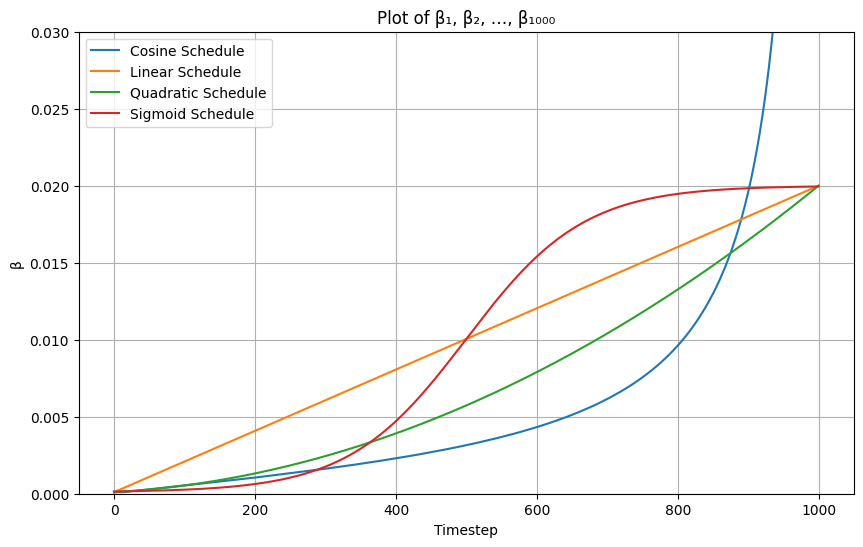

In [35]:
timesteps = 1000

cosine_betas = cosine_beta_schedule(timesteps)
linear_betas = linear_beta_schedule(timesteps)
quadratic_betas = quadratic_beta_schedule(timesteps)
sigmoid_betas = sigmoid_beta_schedule(timesteps)

plt.figure(figsize=(10, 6))
plt.plot(cosine_betas, label='Cosine Schedule')
plt.plot(linear_betas, label='Linear Schedule')
plt.plot(quadratic_betas, label='Quadratic Schedule')
plt.plot(sigmoid_betas, label='Sigmoid Schedule')

plt.xlabel('Timestep')
plt.ylabel('β')
plt.title('Plot of β₁, β₂, …, β₁₀₀₀')
plt.ylim(0, 0.03)
plt.legend()
plt.grid(True)
plt.show()

Now let's compute $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t :=  \alpha_1 \alpha_2 \ldots \alpha_t$.

In [36]:
timesteps = 200

betas = linear_beta_schedule(timesteps=timesteps)

alphas = 1. - betas
alpha_bar = torch.cumprod(alphas, axis=0)

def extract(a, t, x_shape):
    '''Extract the value of a at time t, reshaped to be compatible with x'''
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [37]:
alpha_bar

tensor([0.9999, 0.9997, 0.9994, 0.9990, 0.9985, 0.9979, 0.9972, 0.9964, 0.9955,
        0.9945, 0.9934, 0.9922, 0.9909, 0.9895, 0.9881, 0.9865, 0.9848, 0.9830,
        0.9812, 0.9792, 0.9771, 0.9750, 0.9728, 0.9704, 0.9680, 0.9655, 0.9629,
        0.9602, 0.9574, 0.9545, 0.9516, 0.9485, 0.9454, 0.9422, 0.9389, 0.9355,
        0.9320, 0.9285, 0.9249, 0.9212, 0.9174, 0.9135, 0.9096, 0.9056, 0.9015,
        0.8974, 0.8932, 0.8889, 0.8845, 0.8801, 0.8756, 0.8711, 0.8664, 0.8618,
        0.8570, 0.8522, 0.8474, 0.8425, 0.8375, 0.8325, 0.8274, 0.8223, 0.8171,
        0.8118, 0.8066, 0.8012, 0.7959, 0.7905, 0.7850, 0.7795, 0.7740, 0.7684,
        0.7628, 0.7572, 0.7515, 0.7458, 0.7400, 0.7342, 0.7284, 0.7226, 0.7168,
        0.7109, 0.7050, 0.6991, 0.6931, 0.6872, 0.6812, 0.6752, 0.6692, 0.6632,
        0.6571, 0.6511, 0.6450, 0.6390, 0.6329, 0.6268, 0.6207, 0.6147, 0.6086,
        0.6025, 0.5964, 0.5903, 0.5842, 0.5782, 0.5721, 0.5660, 0.5600, 0.5539,
        0.5479, 0.5419, 0.5358, 0.5298, 

We can use `extract()` to extract the values observed at specific times:

In [38]:
extract(alpha_bar, torch.tensor([1, 2, 3]), [1, 3, 5])

tensor([[[0.9997]],

        [[0.9994]],

        [[0.9990]]])

### Exercise 1: Implement `q_sample` (Forward Diffusion)

Complete the `q_sample` function. This function should take an original image `x0`, a time step `t`, and optionally pre-sampled `noise`, and return the noisy image $\mathbf{x}_t$ according to the "nice property" of the forward diffusion process.

**Formula:**
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I}).$$
This can be implemented by sampling $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and then setting:
$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)} \mathbf{\epsilon},$$

The variables `sqrt_alpha_bar` (which is $\sqrt{\bar{\alpha}_t}$) and `sqrt_one_minus_alpha_bar` (which is $\sqrt{1 - \bar{\alpha}_t}$) have already been pre-computed. You need to use the `extract` function to get the correct values for the given time step `t`.

In [50]:
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alpha_bar_t = extract(sqrt_alpha_bar, t, x0.shape)
    sqrt_one_minus_alpha_bar_t = extract(sqrt_one_minus_alpha_bar, t, x0.shape)

    x_noisy = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise
    return x_noisy


After you are done, run the code below to visualize samples from $q(\mathbf{x}_t | \mathbf{x}_0)$ for $t=0, 50, 100, 150, 199$.

In [51]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy)

  return noisy_image


# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [52]:
img = transformed_dataset['train'][1]['pixel_values']
plot([get_noisy_image(img, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

### Exercise 2: Implement the Loss Function `p_losses`

Complete the `p_losses` function. This function calculates the loss between the true noise and the noise predicted by the denoising model.

**Formula:**
$$ \| \mathbf{\epsilon} - \text{model}(\mathbf{x}_t, t) \|^2 $$
Here, $\mathbf{\epsilon}$ is the `noise` input, and $\text{model}(\mathbf{x}_t, t)$ is the `predicted_noise` returned by `model(x_noisy, t)`. You must use the Mean Squared Error (MSE) loss. [MSE loss documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html).

In [53]:
import torch.nn.functional as F

def p_losses(model, x0, t, noise=None):  # simplified to remove loss_type arg
    if noise is None:
        noise = torch.randn_like(x0)

    # สร้างภาพ noisy x_t
    x_noisy = q_sample(x0=x0, t=t, noise=noise)

    # ให้ model ทำนาย noise จาก x_noisy และ timestep t
    predicted_noise = model(x_noisy, t)

    # คำนวณ Loss: MSE ระหว่าง noise จริงกับ predicted_noise
    loss = F.mse_loss(predicted_noise, noise)

    return loss


### Exercise 3: Implement `p_sample` (Reverse Diffusion Step)

Complete the `p_sample` function. This function performs one step of the reverse diffusion process, estimating $\mathbf{x}_{t-1}$ from $\mathbf{x}_t$.

**Formula:**
$$\mathbf{x}_{t-1} = \underbrace{\frac{1}{\sqrt{\alpha_t}} \left(  \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \text{model}(\mathbf{x}_t, t) \right)}_{\mu_t(\mathbf{x}_t)} + \sigma_t \mathbf{z}$$
where $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ and $\sigma_t^2 = \tilde{\beta}_t = \text{posterior_variance}$.

The term in parentheses corresponds to `model_mean` from the tutorial.
`sqrt_recip_alphas_t` is $\frac{1}{\sqrt{\alpha_t}}$.
`betas_t` is $\beta_t$.
`sqrt_one_minus_alpha_bar_t` is $\sqrt{1 - \bar{\alpha}_t}$.
`posterior_variance_t` is $\sigma_t^2$.

In [75]:
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
alpha_bar_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1. - alpha_bar_prev) / (1. - alpha_bar)

@torch.no_grad()
def p_sample(model, x, t, t_index):
    # Calculate beta_t
    betas_t = extract(betas, t, x.shape)
    # Calculate sqrt(1 - alpha_bar_t)
    sqrt_one_minus_alpha_bar_t = extract(
        sqrt_one_minus_alpha_bar, t, x.shape
    )
    # Calculate 1 / sqrt(alpha_t)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    #### YOUR CODE HERE ####
    # Estimate the mean of the reverse process
    predicted_noise = model(x, t)
    model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alpha_bar_t * predicted_noise)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)

        # x_{t-1} = model_mean + sqrt(posterior_variance_t) * noise
        return model_mean + torch.sqrt(posterior_variance_t) * noise

### Training and Sampling Loop

Below are utilities for training and saving/sampling images. You do not need to modify this part.

In [76]:
# --- Training Utilities ---
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

# Sample and save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    img = torch.randn(shape, device=device)
    imgs = []

    for i in reversed(range(0, timesteps)):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=1): # channels=1 for Fashion-MNIST
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [77]:
# --- Model and Optimizer Setup ---
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

### Exercise 4: Complete the training loop below by calculating the loss function `p_losses` that you just implemented in Exercise 2 (Step 5 in the Algorithm 1 below without "$\nabla_{\theta}$").

<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

In [68]:
# --- Training Loop ---
from torchvision.utils import save_image

epochs = 5

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        #### YOUR CODE HERE ####
        # Calculate the loss in Step 5 of Algorithm 1
        # Use the loss function from Exercise 2
        loss = p_losses(model, batch, t)

        if step % 100 == 0:
            print(f"Epoch {epoch} Step {step} Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

        # save generated images
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = list(map(lambda n: sample(model, image_size=image_size, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow=6)

Epoch 0 Step 0 Loss: 0.1004
Epoch 0 Step 100 Loss: 0.1005
Epoch 0 Step 200 Loss: 0.0895
Epoch 0 Step 300 Loss: 0.1051
Epoch 0 Step 400 Loss: 0.0848
Epoch 1 Step 0 Loss: 0.0874
Epoch 1 Step 100 Loss: 0.1010
Epoch 1 Step 200 Loss: 0.1069
Epoch 1 Step 300 Loss: 0.0924
Epoch 1 Step 400 Loss: 0.1028
Epoch 2 Step 0 Loss: 0.0991
Epoch 2 Step 100 Loss: 0.1018
Epoch 2 Step 200 Loss: 0.0941
Epoch 2 Step 300 Loss: 0.0928
Epoch 2 Step 400 Loss: 0.0906
Epoch 3 Step 0 Loss: 0.0812
Epoch 3 Step 100 Loss: 0.0958
Epoch 3 Step 200 Loss: 0.0816
Epoch 3 Step 300 Loss: 0.0945
Epoch 3 Step 400 Loss: 0.1012
Epoch 4 Step 0 Loss: 0.0846
Epoch 4 Step 100 Loss: 0.0946
Epoch 4 Step 200 Loss: 0.0734
Epoch 4 Step 300 Loss: 0.1062
Epoch 4 Step 400 Loss: 0.0873


In [78]:
# --- Final Sampling ---
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

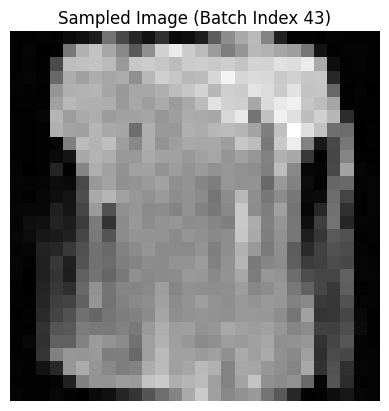

In [79]:
# Show a random sample
random_index = 43
plt.imshow(samples[-1][random_index].reshape(image_size, image_size), cmap="gray")
plt.title(f"Sampled Image (Batch Index {random_index})")
plt.axis('off')
plt.show()

In [80]:
import matplotlib.animation as animation
from IPython.display import HTML

print("Generating GIF of denoising process...")

random_index = 43
fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion_fashion_mnist.gif')
plt.close(fig)
HTML(animate.to_jshtml())

Generating GIF of denoising process...
